# CLV Analysis Prediction

In [15]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import (
    summary_data_from_transaction_data,
    calibration_and_holdout_data,
)
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/cleaned_online_retail_II.csv")
rfm_df = pd.read_csv("data/rfm_analysis.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="%Y-%m-%d %H:%M:%S")
analyse_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

rfm_df.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster,Persona
0,12346,529,11,372.86,1,5,2,152,Loyal Customer,0,At-Risk & Lost
1,12347,2,8,4671.93,5,4,5,545,Recent Customer,1,Loyal & Valuable
2,12348,75,5,1659.40,3,4,4,344,Promising Customers,1,Loyal & Valuable
3,12349,19,3,3498.94,5,3,5,535,Recent Customer,1,Loyal & Valuable
4,12350,310,1,294.40,2,1,2,212,Regular Customer,0,At-Risk & Lost


In [16]:
# Prepare CLV summary data for lifetimes models
clv_df = summary_data_from_transaction_data(
    df,
    customer_id_col='Customer ID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalPrice',
    observation_period_end=analyse_date
)
clv_df.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346,6.0,196.0,726.0,47.143333
12347,7.0,402.0,405.0,580.057143
12348,4.0,363.0,439.0,359.310000
12349,2.0,571.0,590.0,1285.110000
12350,0.0,0.0,311.0,0.000000


In [17]:
# Split data into calibration and holdout to evaluate BG/NBD predictions on unseen period
# We use a 90-day holdout window ending at the last invoice date
holdout_start_date = df['InvoiceDate'].max() - dt.timedelta(days=90)
analyse_date = df['InvoiceDate'].max()

# Build calibration/holdout dataset with required fields for lifetimes
clv_cal_holdout = calibration_and_holdout_data(
    df,
    customer_id_col='Customer ID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalPrice',
    calibration_period_end=holdout_start_date,
    observation_period_end=analyse_date
)

# Fit BG/NBD on calibration period only
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
    clv_cal_holdout['frequency_cal'],
    clv_cal_holdout['recency_cal'],
    clv_cal_holdout['T_cal']
)

# Predict expected number of purchases during the holdout window for each customer
holdout_duration = (analyse_date - holdout_start_date).days
clv_cal_holdout['bgf_preds'] = bgf.predict(
    t=holdout_duration,
    frequency=clv_cal_holdout['frequency_cal'],
    recency=clv_cal_holdout['recency_cal'],
    T=clv_cal_holdout['T_cal']
)

Model 1 (BG/NBD only) RMSE        : 0.9999
Model 2 (XGBoost Hybrid) RMSE     : 0.9630


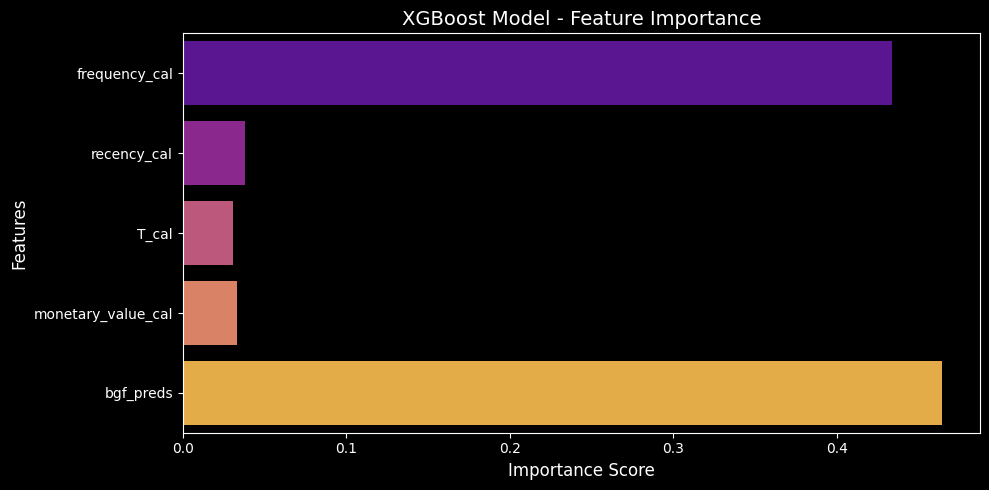

In [18]:
# Hybrid approach: use BG/NBD predictions as a feature in a supervised model to predict holdout purchases

X_hybrid = clv_cal_holdout[['frequency_cal', 'recency_cal', 'T_cal', 'monetary_value_cal', 'bgf_preds']]
y_target = clv_cal_holdout['frequency_holdout']

# Train/test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X_hybrid, y_target, test_size=0.2, random_state=42)

# XGBoost regressor with early stopping to prevent overfitting
xgb_hybrid_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)
# Evaluate on the validation (test) split during training
xgb_hybrid_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Predictions and RMSE for the hybrid model
xgb_preds_test = xgb_hybrid_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_preds_test))

# Baseline: BG/NBD-only predictions (no learning), compare RMSEs
bgnbd_preds_test = X_test['bgf_preds'] 
rmse_bgnbd = np.sqrt(mean_squared_error(y_test, bgnbd_preds_test))

print(f"Model 1 (BG/NBD only) RMSE        : {rmse_bgnbd:.4f}")
print(f"Model 2 (XGBoost Hybrid) RMSE     : {rmse_xgb:.4f}")

# Plot feature importance to interpret hybrid model drivers
importance_corr = xgb_hybrid_model.feature_importances_
plt.figure(figsize=(10, 5))
sns.barplot(x=importance_corr, y=X_hybrid.columns, palette='plasma')
plt.title("XGBoost Model - Feature Importance", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

In [19]:
# Retrain the BG/NBD model with the entire dataset
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
    clv_df['frequency'],
    clv_df['recency'],
    clv_df['T']
)

<lifetimes.BetaGeoFitter: fitted with 5814 subjects, a: 0.08, alpha: 64.42, b: 1.27, r: 0.67>

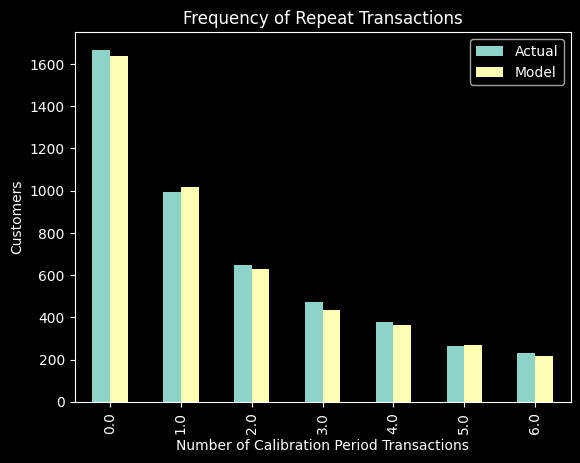

In [20]:
# Plot expected vs actual number of repeat transactions per customer
plot_period_transactions(bgf);

In [21]:
# Assumption check: Is there correlation between frequency and monetary?
print("\nFrequency and Monetary Correlation:")
subset = clv_df[['frequency', 'monetary_value']].dropna()
if subset.empty:
    print("Warning: No data available to compute correlation.")
else:
    display(subset.corr())

# Use Gamma-Gamma model
if (clv_df['frequency'] > 0).sum() == 0:
    raise ValueError("No customers with frequency > 0 for Gamma-Gamma fit.")

ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(clv_df[clv_df['frequency'] > 0]['frequency'],
        clv_df[clv_df['frequency'] > 0]['monetary_value'])

# Predict expected average profit for each customer
clv_df['expected_average_profit'] = ggf.conditional_expected_average_profit(
    clv_df['frequency'],
    clv_df['monetary_value']
)

print("\nExpected Average Basket Value (Top 10):")
display(clv_df.sort_values("expected_average_profit", ascending=False).head(10))


Frequency and Monetary Correlation:


,frequency,monetary_value
frequency,1.000000,0.281699
monetary_value,0.281699,1.000000



Expected Average Basket Value (Top 10):


,frequency,recency,T,monetary_value,expected_average_profit
Customer ID,,,,,
12357,1.0,355.0,389.0,6182.670000,7472.625148
12378,1.0,433.0,563.0,3948.140000,4773.498978
12415,19.0,503.0,528.0,4679.955263,4722.937150
14088,13.0,411.0,422.0,3877.227692,3929.542315
14646,88.0,736.0,738.0,3849.329886,3856.916126
12753,5.0,340.0,363.0,3458.260000,3582.324824
17084,1.0,361.0,397.0,2747.990000,3323.817714
14096,16.0,97.0,102.0,3260.412500,3296.103583
17511,49.0,735.0,738.0,3079.497551,3090.429285


In [22]:
# Predict 6-month CLV
# time: Number of months to predict
# freq: Unit of T (D=Day, W=Week, M=Month)
# discount_rate: Monthly discount rate (reflects time value of money)
clv_final = ggf.customer_lifetime_value(
    bgf,
    clv_df['frequency'],
    clv_df['recency'],
    clv_df['T'],
    clv_df['monetary_value'],
    time=6,  # 6-month prediction
    freq="D", # T unit is Day
    discount_rate=0.01 # Monthly 1% discount
)

# Add CLV column to main dataframe
clv_df['clv_6_months'] = clv_final

print("\n6-Month Predicted CLV (Top 10 Customers):")
display(clv_df.sort_values("clv_6_months", ascending=False).head(10))


6-Month Predicted CLV (Top 10 Customers):


,frequency,recency,T,monetary_value,expected_average_profit,clv_6_months
Customer ID,,,,,,
14646,88.0,736.0,738.0,3849.329886,3856.916126,73438.384556
14911,246.0,737.0,739.0,1069.908089,1070.672307,56671.001030
14096,16.0,97.0,102.0,3260.412500,3296.103583,55203.183594
14156,111.0,729.0,739.0,1585.483514,1587.979376,37967.598461
17511,49.0,735.0,738.0,3079.497551,3090.429285,32936.605969
13694,80.0,732.0,736.0,1617.077625,1620.610844,28133.443615
18102,44.0,738.0,739.0,2799.950227,2811.031196,26910.991701
12415,19.0,503.0,528.0,4679.955263,4722.937150,26732.509497
15311,195.0,738.0,739.0,572.723692,573.248701,24070.647924


In [23]:
# Create segments based on CLV scores
clv_df['segment'] = pd.qcut(clv_df['clv_6_months'], 4, labels=["Low Value", "Medium Value", "High Value", "Champion"])

print("\nCustomer Distribution by CLV Segment:")
display(clv_df['segment'].value_counts())

# Examine segment characteristics
print("\nAverage Values by Segment:")
display(clv_df.groupby('segment').agg({
    'clv_6_months': 'mean',
    'frequency': 'mean',
    'recency': 'mean',
    'T': 'mean',
    'monetary_value': 'mean'
}).round(2))


Customer Distribution by CLV Segment:


segment
Low Value       1454
Champion        1454
Medium Value    1453
High Value      1453
Name: count, dtype: int64


Average Values by Segment:


,clv_6_months,frequency,recency,T,monetary_value
segment,,,,,
Low Value,-10.51,0.00,0.00,303.45,0.00
Medium Value,83.46,1.98,219.07,572.51,165.03
High Value,367.43,3.95,395.62,506.26,316.90
Champion,1952.93,12.42,478.20,515.00,540.82


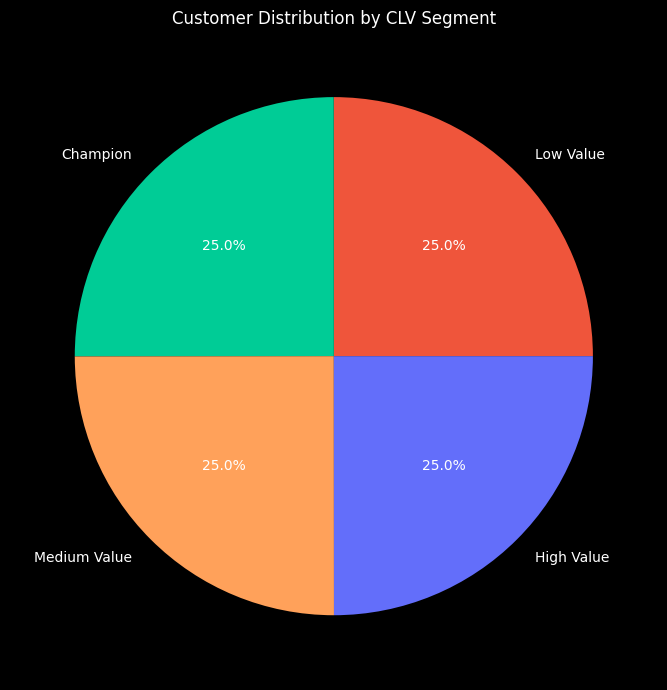

In [24]:
# Define color palette for CLV segments
clv_segment_palette = {
    "Low Value": "#EF553B",
    "Medium Value": "#FFA15A",
    "High Value": "#636efa",
    "Champion": "#00cc96"
}

# Create pie chart for CLV segment distribution
fig, ax = plt.subplots(figsize=(7, 7))
clv_df['segment'].value_counts().plot.pie(
    ax=ax,
    autopct='%1.1f%%',
    colors=[clv_segment_palette[s] for s in clv_df['segment'].value_counts().index]
)
ax.set_title('Customer Distribution by CLV Segment')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

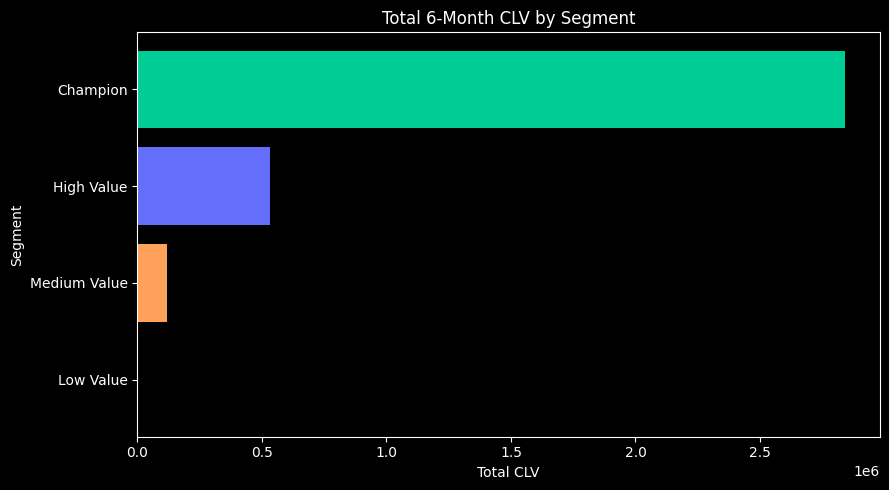

In [25]:
# Total 6-month CLV by segment
segment_total_clv = clv_df.groupby('segment')['clv_6_months'].sum().clip(lower=0).sort_values()

plt.figure(figsize=(9, 5))
plt.barh(segment_total_clv.index, segment_total_clv.values,
         color=[clv_segment_palette[s] for s in segment_total_clv.index])
plt.title('Total 6-Month CLV by Segment')
plt.xlabel('Total CLV')
plt.ylabel('Segment')
plt.tight_layout()
plt.show()

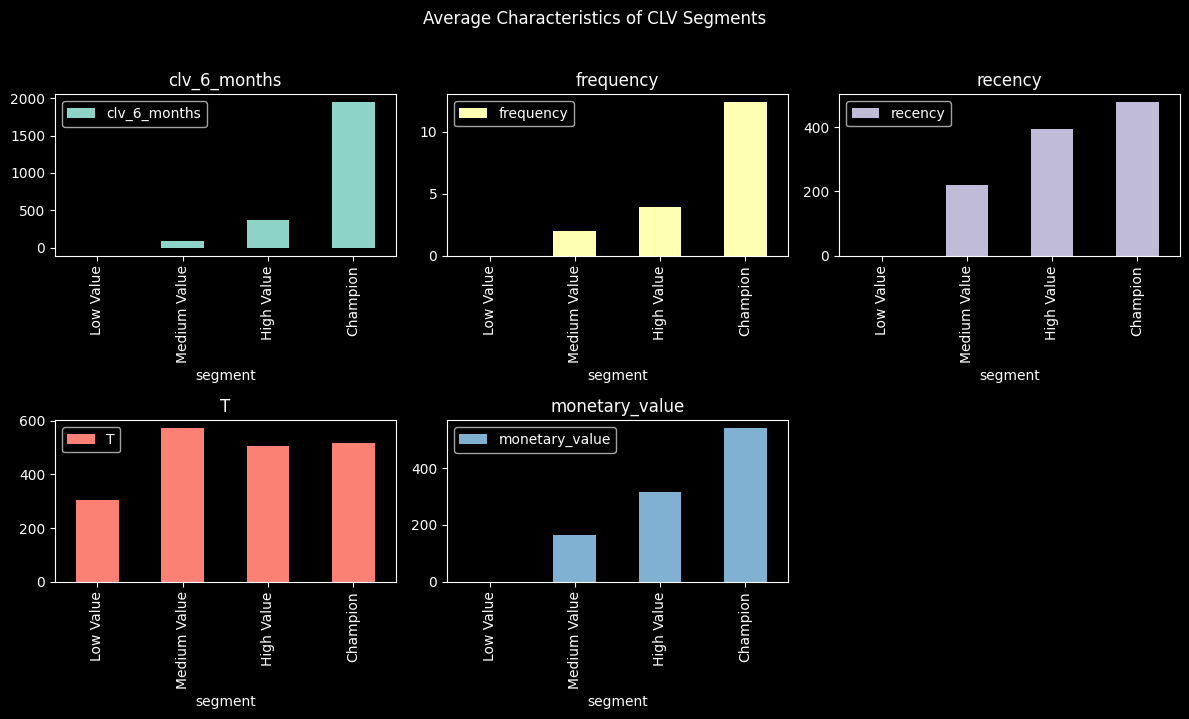

In [26]:
# Calculate mean values for each CLV segment
clv_segment_means = clv_df.groupby('segment').agg({
    'clv_6_months': 'mean',
    'frequency': 'mean',
    'recency': 'mean',
    'T': 'mean',
    'monetary_value': 'mean'
}).round(2)

# Create bar charts showing average characteristics of each segment
clv_segment_means.plot(kind='bar', subplots=True, layout=(2, 3), figsize=(12, 7), sharex=False)
plt.suptitle('Average Characteristics of CLV Segments', y=1.02)
plt.tight_layout()
plt.show()


CLV Segments vs RFM Segments:


Segment,At Risk,Best Customers,Big Spender,Lost Customer,Loyal & Recent,Loyal Big Spenders,Loyal Customer,Promising Customers,Recent Customer,Regular Customer
segment,,,,,,,,,,
Low Value,217,0,5,300,0,0,0,2,77,853
Medium Value,91,0,11,473,4,24,25,236,91,498
High Value,0,5,22,40,58,29,122,745,212,220
Champion,0,466,174,0,33,369,28,124,231,29


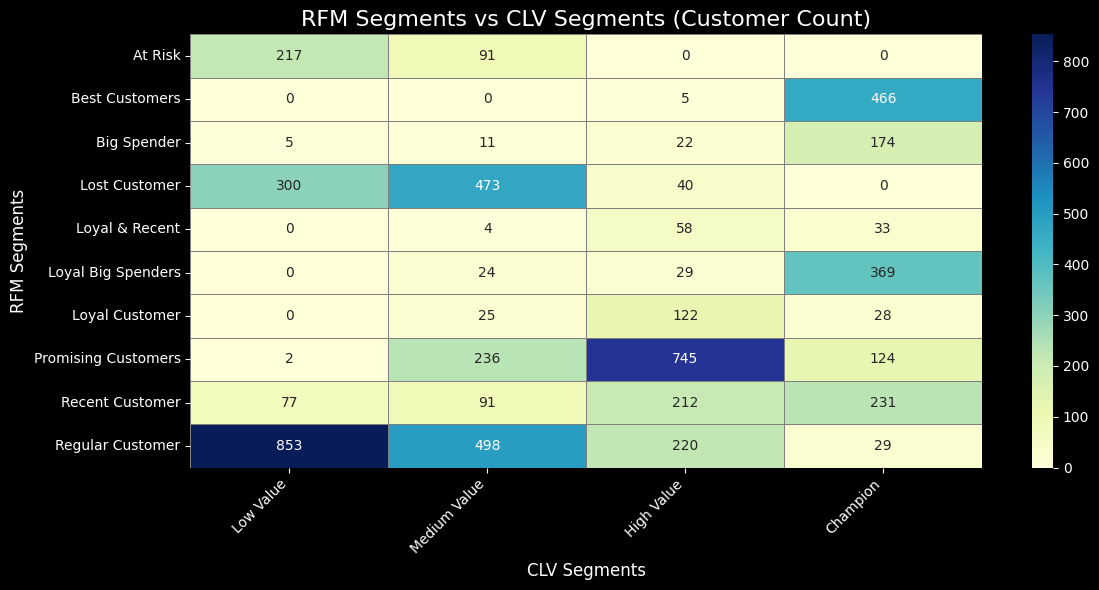

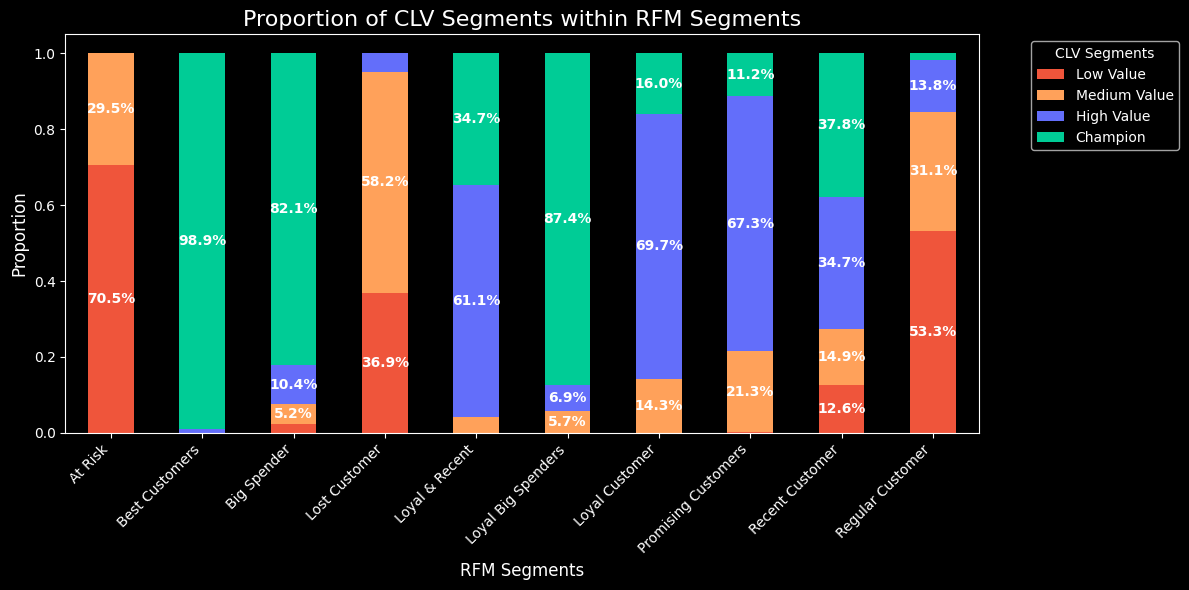

In [27]:
# Segment comparison with RFM segments
merged_df = pd.merge(clv_df, rfm_df[['Customer ID', 'Segment']], 
                     left_index=True, right_on='Customer ID', how='left')

print("\nCLV Segments vs RFM Segments:")
display(pd.crosstab(merged_df['segment'], merged_df['Segment']))

# Visualization comparing RFM segments and CLV segments
plt.figure(figsize=(12, 6))

# Create crosstab for heatmap
crosstab = pd.crosstab(merged_df['Segment'], merged_df['segment'])

# Create heatmap
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu', 
            linewidths=.5, linecolor='gray')
plt.title('RFM Segments vs CLV Segments (Customer Count)', fontsize=16)
plt.xlabel('CLV Segments', fontsize=12)
plt.ylabel('RFM Segments', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Bar chart showing proportions with values
crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0)
ax = crosstab_norm.plot(kind='bar', stacked=True, figsize=(12, 6), 
                   color=[clv_segment_palette[s] for s in crosstab_norm.columns])

# Add value annotations to each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0.05:  # Only show labels for segments >5%
        ax.text(x + width/2, 
                y + height/2, 
                f'{height:.1%}', 
                horizontalalignment='center',
                verticalalignment='center',
                color='white',
                fontweight='bold')

plt.title('Proportion of CLV Segments within RFM Segments', fontsize=16)
plt.xlabel('RFM Segments', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='CLV Segments', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

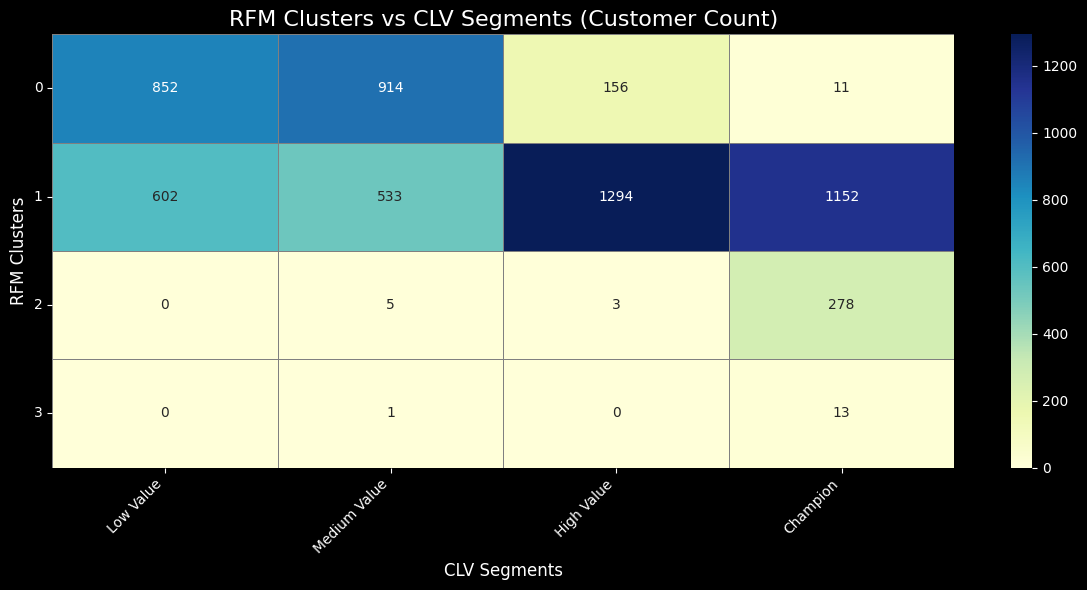

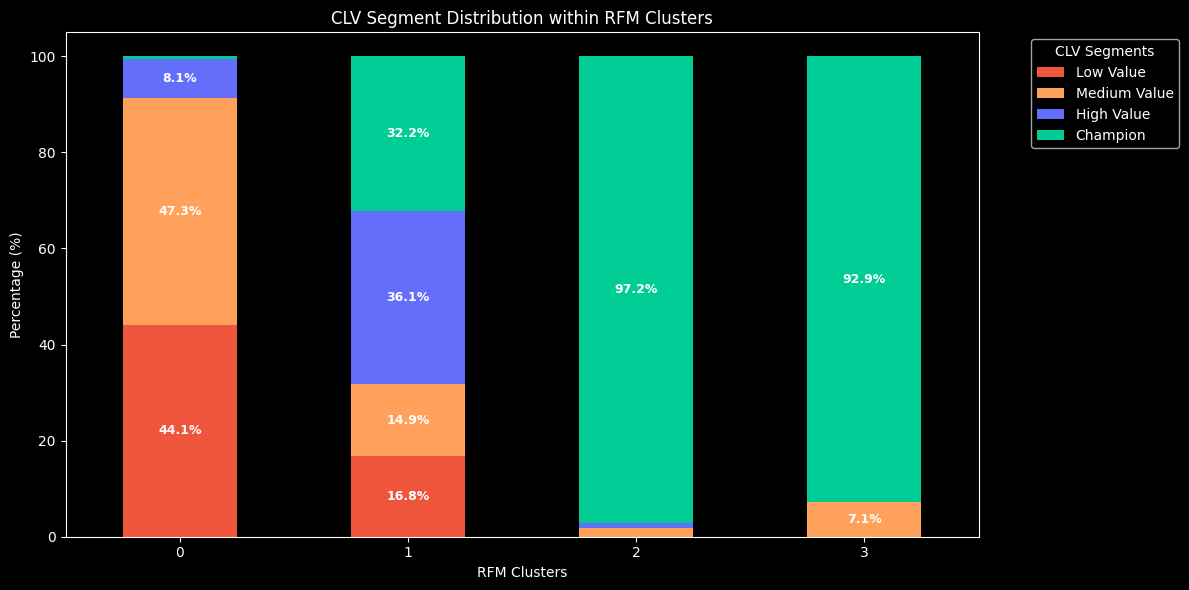

In [28]:
# RFM Cluster vs CLV Segment comparison
plt.figure(figsize=(12, 6))

# Heatmap showing relationship between clusters and CLV segments
cluster_clv_crosstab = pd.crosstab(rfm_df['Cluster'], merged_df['segment'])

# Heatmap
sns.heatmap(cluster_clv_crosstab, annot=True, fmt='d', cmap='YlGnBu',
            linewidths=.5, linecolor='gray')
plt.title('RFM Clusters vs CLV Segments (Customer Count)', fontsize=16)
plt.xlabel('CLV Segments', fontsize=12)
plt.ylabel('RFM Clusters', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# CLV segment distribution (%) within each cluster
cluster_clv_pct = cluster_clv_crosstab.div(cluster_clv_crosstab.sum(axis=1), axis=0) * 100
ax = cluster_clv_pct.plot(kind='bar', stacked=True, figsize=(12, 6),
                          color=[clv_segment_palette[s] for s in cluster_clv_pct.columns],
                          title='CLV Segment Distribution within RFM Clusters')
plt.xlabel('RFM Clusters'); plt.ylabel('Percentage (%)'); plt.xticks(rotation=0)
plt.legend(title='CLV Segments', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    if p.get_height() > 2:
        ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2,
                f'{p.get_height():.1f}%', ha='center', va='center',
                color='white', fontweight='bold', fontsize=9)

plt.tight_layout(); plt.show()
